In [19]:
import sys
import time
import pickle
import numpy as np
import pandas as pd

from multiprocessing import Pool

from skimage import io
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras 
from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

from scripts.image import load_image

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
img_rows, img_cols = 224, 224

In [3]:
images_preloaded = True
try:
    with open('data/images.pickle', 'rb') as handle:
        features, labels =  pickle.load(handle)
except:
    images_preloaded = False

In [4]:
# load images into memory
if(not images_preloaded):
    with open('data/tmdb_info.pickle', 'rb') as handle:
        tmdb_dict =  pickle.load(handle)
    with Pool(6) as p:
        rs = p.map_async(load_image, list(tmdb_dict.keys()))
        p.close()
        while (True):
            if (rs.ready()): break
            remaining = rs._number_left
            print("Waiting for", remaining, "tasks to complete...")
            time.sleep(10)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 23 tasks to complete...
Waiting for 19 tasks to complete...
Waiting for 15 tasks to complete...
Waiting for 11 tasks to complete...
Waiting for 8 tasks to complete...
Waiting for 5 tasks to complete...
Waiting for 2 tasks to complete...


In [5]:
# extract labes for the loaded images
if(not images_preloaded):
    labels = []
    features = []
    for r in rs.get():
        if(r[1] is not None):
            d = tmdb_dict[r[0]].__dict__
            labels.append([g['name']  for g in   d['genres']])
            features.append(r[1])
    features = np.asarray(features)
    rs = None
    tmdb_dict = None

In [6]:
# create the labels vector
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print('label matrix shape:', y.shape)

label matrix shape: (58827, 20)


In [7]:
# split into test / train data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state = 442)

In [8]:
pca = PCA(n_components = 10)
y_train_pca = pca.fit_transform(y_train)
y_test_pca = pca.transform(y_test)
output_size = y_train_pca.shape[1]

In [9]:
print('Train label matrix shape:', y_train_pca.shape)
print('Train predictor matrix shape:', X_train.shape)
print('Test label matrix shape:', y_test_pca.shape)
print('Test predictor matrix shape:', X_test.shape)

Train label matrix shape: (44120, 10)
Train predictor matrix shape: (44120, 224, 224, 3)
Test label matrix shape: (14707, 10)
Test predictor matrix shape: (14707, 224, 224, 3)


Model definition

In [17]:
def get_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer = regularizers.l1(0.01)))
    model.add(Dense(output_size, kernel_initializer='glorot_uniform'))
    return model

In [24]:
model = None
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 24, 128)       73856     
__________

In [25]:
earlyStopping = EarlyStopping(
    monitor='val_loss', patience = 5, min_delta = 0.01, verbose = 0, mode = 'auto')
tensorboard = TensorBoard(
    log_dir='logs/cnn_pca', histogram_freq=1, write_graph=True, write_images=False)
sgd = SGD(lr = 0.1, decay = 1e-6, momentum = 0.9)

In [26]:
model.compile(optimizer = 'nadam', loss = 'mean_squared_error', metrics=['mae'])

In [27]:
history = model.fit(
    X_train, 
    y_train_pca, 
    batch_size = 512, 
    epochs = 50, 
    verbose = 1,
    validation_data = (X_test, y_test_pca),
    callbacks = [earlyStopping]
)

Train on 44120 samples, validate on 14707 samples
Epoch 1/50
44120/44120 [==============================] - 209s - loss: 48.6701 - mean_absolute_error: 0.2412 - val_loss: 19.8254 - val_mean_absolute_error: 0.2405
Epoch 2/50
44120/44120 [==============================] - 208s - loss: 18.9517 - mean_absolute_error: 0.2405 - val_loss: 18.0980 - val_mean_absolute_error: 0.2403
Epoch 3/50
44120/44120 [==============================] - 207s - loss: 18.7322 - mean_absolute_error: 0.2405 - val_loss: 19.3386 - val_mean_absolute_error: 0.2464
Epoch 4/50
44120/44120 [==============================] - 207s - loss: 18.5484 - mean_absolute_error: 0.2406 - val_loss: 17.7694 - val_mean_absolute_error: 0.2403
Epoch 5/50
44120/44120 [==============================] - 206s - loss: 18.3477 - mean_absolute_error: 0.2406 - val_loss: 18.9297 - val_mean_absolute_error: 0.2397
Epoch 6/50
44120/44120 [==============================] - 207s - loss: 18.1686 - mean_absolute_error: 0.2404 - val_loss: 17.4187 - val_

In [28]:
y_pred_test_pca = model.predict(X_test)
y_pred_test = pca.inverse_transform(y_pred_test_pca)

In [45]:
y_pred_test_cls = np.zeros(y_pred_test.shape)
y_pred_test_cls[y_pred_test > 0.5] = 1

In [44]:
print(y_test[10])
print(y_test_pca[10])
print(y_pred_test_pca[10])
print(y_pred_test_cls[10])

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[-0.52270162  0.65574569 -0.06178874 -0.09686353  0.06575172 -0.17593735
  0.04067854  0.01139354  0.00482788 -0.04374503]
[-0.00163054  0.00169657 -0.00425679  0.00207877 -0.00011466  0.00224551
  0.00420723  0.00253882 -0.00304022  0.00472961]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]


In [46]:
print(classification_report(y_test, y_pred_test_cls, target_names = mlb.classes_))

                 precision    recall  f1-score   support

         Action       0.00      0.00      0.00      1550
      Adventure       0.00      0.00      0.00       871
      Animation       0.00      0.00      0.00      1014
         Comedy       0.25      1.00      0.41      3746
          Crime       0.00      0.00      0.00       925
    Documentary       0.00      0.00      0.00      2122
          Drama       0.36      1.00      0.53      5366
         Family       0.00      0.00      0.00       860
        Fantasy       0.00      0.00      0.00       547
        Foreign       0.00      0.00      0.00       488
        History       0.00      0.00      0.00       329
         Horror       0.00      0.00      0.00      1275
          Music       0.00      0.00      0.00      1116
        Mystery       0.00      0.00      0.00       502
        Romance       0.00      0.00      0.00      1541
Science Fiction       0.00      0.00      0.00       624
       TV Movie       0.00    

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


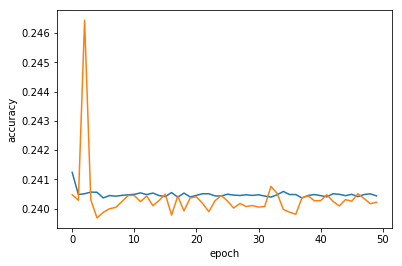

In [50]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [51]:
model.save('models/cnn_pca.h5')